# Two coupled TLS: the effect of decoherence on entanglement

TLS = two-level system

The Core Phenomenon: Entanglement Sudden Death (ESD)

In [21]:
# -q flag used to suppress useless output
!pip -q install numpy matplotlib qutip ipywidgets

import numpy as np
from qutip import *
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from qutip import Bloch
from matplotlib import rc
rc('animation', html='jshtml')
plt.rcParams['animation.embed_limit'] = 90.0
from IPython.display import display, Image
from ipywidgets import interact, widgets
from IPython.display import display, clear_output

w = 1.0 * 2 * np.pi  # Qubit frequency = 1 Hz
J = 0.5 * 2 * np.pi  # Coupling strength between qubits = 0.5 Hz = the exchange (Vacuum Rabi) frequency
gamma = 0.2          # Decay rate (dissipation strength)
# Characteristic lifetime of the system: T1 ~ 1/gamma => "Death" happens after ~ 5s

times = np.linspace(0, 10, 200) # [0.0, 0.05, 0.1, ..., 9.95, 10.0]

# 2-qubit Hilber space (4 dimensions)
# |00> = |0> x |0> = (1,0,0,0)
# |01> = |0> x |1> = (0,1,0,0)
# |10> = |1> x |0> = (0,0,1,0)
# |11> = |1> x |1> = (0,0,0,1)

# Qubit 1 operators (act on 1st subspace and leave 2nd subspace unchanged)
sz1 = tensor(sigmaz(), qeye(2)) # Measure Z-Spin (here equivalent to measuring the Energy)
sp1 = tensor(sigmap(), qeye(2)) # Raising
sm1 = tensor(sigmam(), qeye(2)) # Lowering (decay)

# Qubit 2 operators (act on 2nd subspace and leave 1st subspace unchanged)
sz2 = tensor(qeye(2), sigmaz()) # Measure Z-Spin (here equivalent to measuring the Energy)
sp2 = tensor(qeye(2), sigmap()) # Raising
sm2 = tensor(qeye(2), sigmam()) # Lowering (decay)

# The Hamiltonian = Individual energies + Interaction term (Exchange interaction)
H = 0.5 * w * (sz1 + sz2) + J * (sm1 * sp2 + sp1 * sm2)

## Scenario A: Independent Baths (The "Bad" Case)

When qubits are coupled to separate reservoirs (e.g., two distant atoms emitting spontaneously), decoherence attacks them individually.Mechanism: The environment effectively measures the state of each qubit independently, destroying the phase relationship between $|01\rangle$ and $|10\rangle$.Outcome: This is the primary scenario for ESD. The stronger the noise (amplitude damping or phase damping), the faster $C(t)$ hits zero.

## Scenario B: Common Bath (The "Interesting" Case)
When qubits effectively share an environment (e.g., two spins coupled to the same phonon mode), collective effects emerge. The phase of the noise acting on Qubit A is correlated with the noise on Qubit B.

### Superradiance (Fast Death)
If the qubits are in a symmetric state (like the triplet state $|\Psi_+\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$), the noise interferes constructively.
- Effect: The system decays faster than a single independent qubit ($\Gamma_{collective} \approx 2\Gamma_{single}$). Entanglement dies very quickly.

### Subradiance & Decoherence-Free Subspaces (DFS)
If the qubits are in an antisymmetric state (like the singlet $|\Psi_-\rangle = \frac{|01\rangle - |10\rangle}{\sqrt{2}}$), the noise can interfere destructively.
- Effect: If the coupling is perfectly symmetric, the environment cannot distinguish between the two qubits to flip just one of them.
- Result: The state becomes "invisible" to the noise. The entanglement is protected and can theoretically persist indefinitely (or decay on much slower timescales), forming a Decoherence-Free Subspace (DFS).

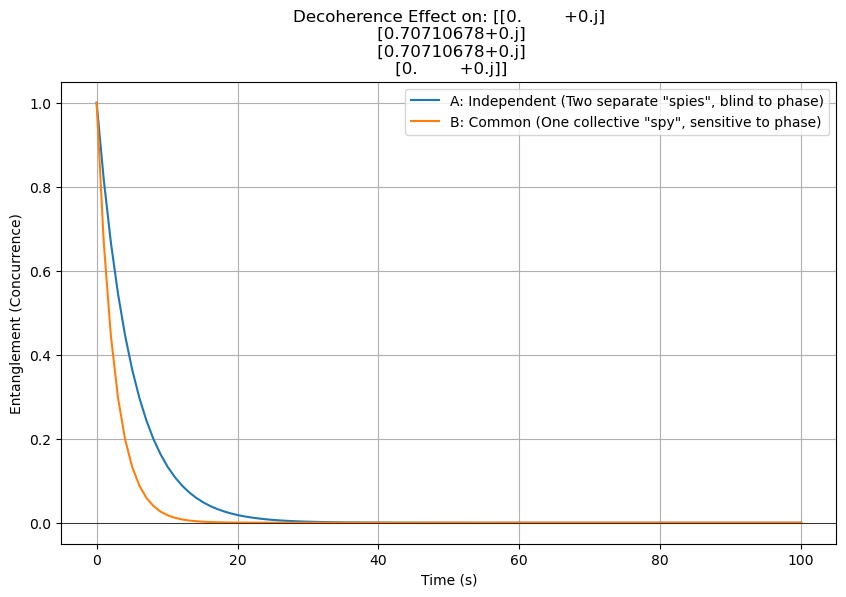

Rendering GIF...


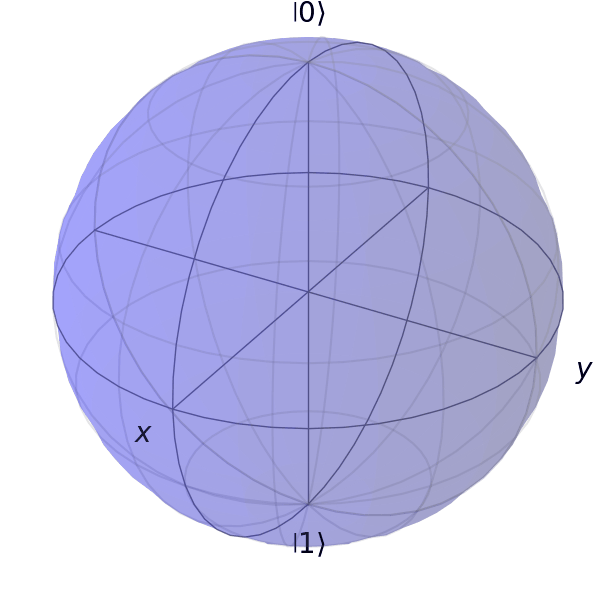

Rendering GIF...


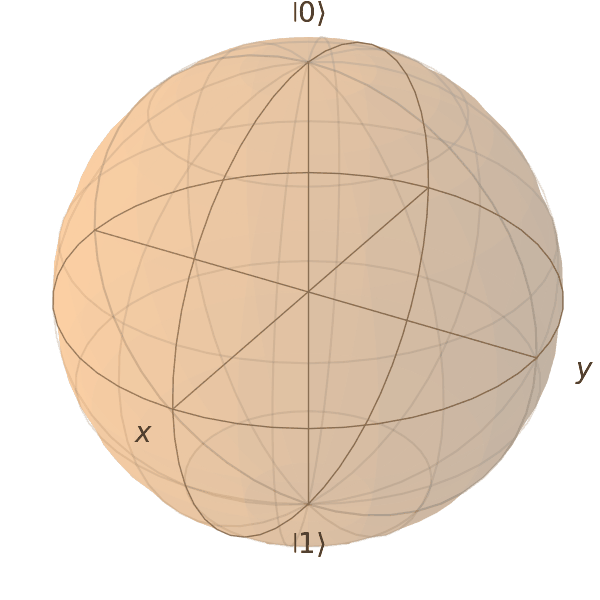

In [28]:
def get_bloch_vectors(result):
    # Define operators for Qubit 1 (acts on first space, identity on second)
    sx1 = tensor(sigmax(), qeye(2))
    sy1 = tensor(sigmay(), qeye(2))
    sz1 = tensor(sigmaz(), qeye(2))

    # Define operators for Qubit 2 (identity on first, acts on second
    sx2 = tensor(qeye(2), sigmax())
    sy2 = tensor(qeye(2), sigmay())
    sz2 = tensor(qeye(2), sigmaz())

    # Lists to store bloch vectors [x, y, z] for every time step
    vectors_q1 = []
    vectors_q2 = []

    for rho in result.states:
        # Calculate expectation values
        # Qubit 1
        v1 = [expect(sx1, rho), expect(sy1, rho), expect(sz1, rho)]

        # Qubit 2
        v2 = [expect(sx2, rho), expect(sy2, rho), expect(sz2, rho)]

        vectors_q1.append(v1)
        vectors_q2.append(v2)

    return np.array(vectors_q1), np.array(vectors_q2)

def visualize_electron_spins(result_A, sphere_color):
    # Get data
    vecs_q1, vecs_q2 = get_bloch_vectors(result_A)

    # Setup Figure
    fig = plt.figure(figsize=(6, 6))
    b = Bloch(fig=fig)
    b.vector_color = ['r', 'b']
    b.point_color = ['r', 'b']
    b.point_marker = ['o']
    b.sphere_color = sphere_color


    # Initial draw
    b.make_sphere()

    def animate(i):
        b.clear()

        # Qubit 1 (Red)
        b.add_vectors(vecs_q1[i])
        # only draw line if we have at least 2 points (i > 0)
        if i > 0:
            b.add_points([vecs_q1[:i+1, 0], vecs_q1[:i+1, 1], vecs_q1[:i+1, 2]], meth='l')

        # Qubit 2 (Blue)
        b.add_vectors(vecs_q2[i])
        if i > 0:
            b.add_points([vecs_q2[:i+1, 0], vecs_q2[:i+1, 1], vecs_q2[:i+1, 2]], meth='l')

        b.make_sphere()
        return []

    # Create Animation
    anim = animation.FuncAnimation(fig, animate, frames=len(vecs_q1), blit=False)
    print("Rendering GIF...")
    anim.save('spin_dynamics.gif', writer='pillow', fps=10)

    plt.close(fig)
    display(Image(filename='spin_dynamics.gif'))

def visualise_bloch_sphere(res):
    res_a, res_b = res
    visualize_electron_spins(res_a, '#0000FF15')
    visualize_electron_spins(res_b, '#FF800015')

def simulate(psi):
    # Baths
    # Scenario A: Independent (Two separate "spies", blind to phase)
    c_ops_A = [np.sqrt(gamma) * sm1, np.sqrt(gamma) * sm2]

    # Scenario B: Common (One collective "spy", sensitive to phase)
    c_ops_B = [np.sqrt(gamma) * (sm1 + sm2)]

    # Simulations
    result_A = mesolve(H, psi, times, c_ops_A) # uses the Lindblad Master Equation
    result_B = mesolve(H, psi, times, c_ops_B)

    # Entanglement
    conc_A = [concurrence(rho) for rho in result_A.states]
    conc_B = [concurrence(rho) for rho in result_B.states]

    plt.figure(figsize=(10, 6))
    plt.plot(times, conc_A, label='A: Independent (Two separate "spies", blind to phase)')
    plt.plot(times, conc_B, label='B: Common (One collective "spy", sensitive to phase)')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.title(f'Decoherence Effect on: {psi.full()}')
    plt.xlabel('Time (s)')
    plt.ylabel('Entanglement (Concurrence)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return result_A, result_B

# Initial States
# Tried to use Qobj([0, 1, 1, 0]), but then you need to manually specify dims
# Symmetric (Triplet) - "Bright"
psi_bright = (ket("01") + ket("10")).unit()

# Antisymmetric (Singlet) - "Dark"
psi_dark = (ket("01") - ket("10")).unit()

visualise_bloch_sphere(simulate(psi_bright))

visualise_bloch_sphere(simulate(psi_dark))



In [23]:
res = None

def run_simplified_control(amp00, amp01, amp10, amp11):
    global res
    psi_raw = (amp00 * ket("00") +
               amp01 * ket("01") +
               amp10 * ket("10") +
               amp11 * ket("11"))

    # .unit() gives ZeroDivisionError when norm is 0
    if psi_raw.norm() == 0:
        psi0 = ket("00")
    else:
        psi0 = psi_raw.unit()

    res = simulate(psi0)

interact(run_simplified_control,
         amp00=FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='|00>'),
         amp01=FloatSlider(value=1.0, min=-1.0, max=1.0, step=0.1, description='|01>'),
         amp10=FloatSlider(value=1.0, min=-1.0, max=1.0, step=0.1, description='|10>'),
         amp11=FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='|11>')
)

btn_viz = widgets.Button(
    description='Visualize Bloch Spheres (3D)',
    button_style='warning',
    icon='video-camera',
    layout=widgets.Layout(width='50%')
)
out_viz = widgets.Output()
def on_btn_click(b):
    global res
    with out_viz:
        clear_output()
        visualise_bloch_sphere(res)

btn_viz.on_click(on_btn_click)

display(widgets.VBox([
    btn_viz,
    out_viz
]))

# interesting states configs:
# |00> 1, |01> 1, |10> -1, |11> -1      # opposing vectors converging downwards
# |00> 0, |01> 1, |10> 0, |11> 0        # vectors started opposing, converge on half of the length to |1>

interactive(children=(FloatSlider(value=0.0, description='|00>', max=1.0, min=-1.0), FloatSlider(value=1.0, de…

# Unused stuff (yet, from Matei)

In [24]:
#creating an entangled TLS (bell state)

tls = tensor(basis(2,0), basis(2,0))
#visualise the tls

#apply hadamard on first, identity on second
H1 = tensor(gates.hadamard_transform(),qeye(2))

tls = H1 * tls

print(tls)

bell = gates.cnot()*tls

print(bell)

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.70710678]
 [0.        ]]
Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]


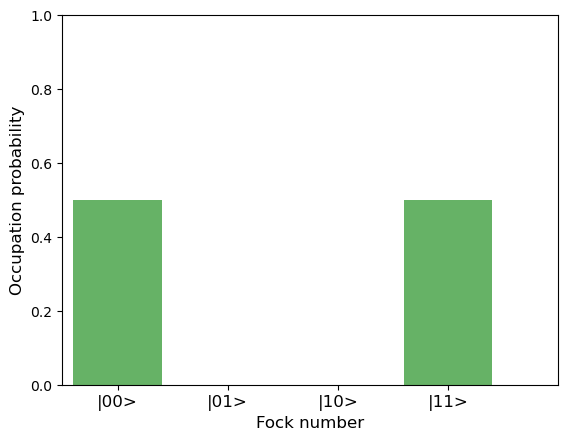

In [25]:

#label the bell and plot the TLS
labels = ["|00>", "|01>", "|10>", "|11>"]
plot_fock_distribution(bell, labels)
plt.show()


In [26]:
#adding time
times = np.linspace(0, 100, 100)
H = 0 * tensor(qeye(2), qeye(2))

#decoherence rate (gamma). ideal case = 0
gamma_phase, gamma_relax = 0, 0

#create operators
sm = destroy(2) #destruction (lowering) operator

#collapse operators list
c_ops = []

#qubit 0
c_ops.append(np.sqrt(gamma_relax) * tensor(sm, qeye(2)))   #relaxation
c_ops.append(np.sqrt(gamma_phase) * tensor(sigmaz(), qeye(2)))  #dephasing

#qubit 1
c_ops.append(np.sqrt(gamma_relax) * tensor(qeye(2), sm))
c_ops.append(np.sqrt(gamma_phase) * tensor(qeye(2), sigmaz()))

result = mesolve(H, bell, times, c_ops, [])


/opt/homebrew/anaconda3/envs/kwant-env/lib/python3.11/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


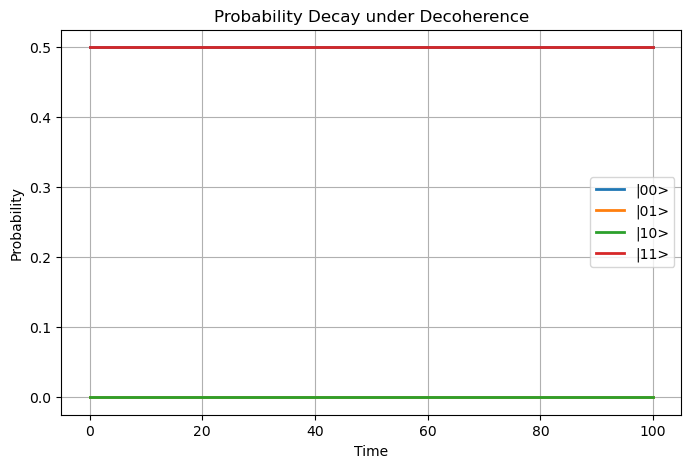

In [27]:
#probability dimensions: 4 states x timesteps
probs = np.zeros((4, len(times)))

#probabilities from density matrix
for t_idx, rho in enumerate(result.states):
    probs[:, t_idx] = np.real(rho.diag())

#plots
plt.figure(figsize=(8, 5))
labels = ["|00>", "|01>", "|10>", "|11>"]

for s_idx in range(4):
    plt.plot(times, probs[s_idx], label=labels[s_idx], linewidth=2)

plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Probability Decay under Decoherence")
plt.legend()
plt.grid(True)
plt.show()